# Face recognition using Deep Learning
In this second part of the third assignment, you will be able to have a look into recent, Deep Learning based , methodologies for face recognition.

Similar to assignment 2, you will generate an enriched representation of faces that you can use in simple or more complicated classification algorithms. 

## Metric Learning

Instead of building networks that are trained end-to-end to perform face recognition, metric learning based methods learn a projection of the input data on a low-dimensional vector, such that classification in that lower-dimensional space is much easier and can be performed using simple distance metrics. 

## Two major approaches

In the context of face recognition we can observe two major Deep Learning based approaches since 2014.

1. The first approach was developed and presented in 2014 by researchers at Facebook and is called [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) . The major contributions where a CDNN to classify faces. In addition a 3D/2D alignment procedure is applied prior to classification. 
The CDNN is trained as a classifier on the SFC (Social Face Classification) dataset, which is a very large (4.4 million image of 4000 individuals) dataset. This setting is called supervised.  The challenge is whether this can also be generalizd to other datasets and subjects as well. By training it on the large collection of uncontrolled images, an embedded representation (the vector description prior to the classification layer) can be generated that is, allegedly, generalizable to other face recognition data. One can then use this representation as we have previously done for classical representations. 
By way of demonstration they tested it on the LFW dataset to achieve >0.95% verification accuracy. 

2. In the same paper they also tested a [siamese network](https://en.wikipedia.org/wiki/Siamese_network) DNN architecture for generating embedded vector representations.  This consists of two copies of the same CNN (sharing their weights) that are applied to pairs of images. During training the distance between the embedded representations of the same individual is minimized, and the distances between embedded representations of different individuals is maximized. In the mean time, this work was extended, steadily increasing the performance. Siamese networks are an example of *One-shot Learning* where you typically have very few samples per object or dynamically changing number of objects/subjects. While [this link](https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d) tests it on a non-face recognition task, it can be applied to face recognition as well (see the *Siamese for ATT* notebook included).


3. The second approach was developed by researchers at Google.  An in-depth presentation of their FaceNet/OpenFace deep CNN's for metric embedding of faces is given by [Martin Krasser et al](http://krasserm.github.io/2018/02/07/deep-face-recognition/). Note that this method was trained on 200 million images of eight million identities. The main methodological point is that these networks are trained using a special loss-function: the triplet loss function. 
>This function is minimized when the distance between an anchor image $x_{ai}$ and a positive image $x_{pi}$ (same identity) in embedding space is smaller than the distance between that anchor image and a negative image $x_{ni}$ (different identity) by at least a margin $\alpha$. Model training aims to learn an embedding f(x) of image x such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large. 

From the [Dlib face_recognition.py](https://github.com/davisking/dlib/blob/master/python_examples/face_recognition.py) code, we get an application view of the embedding:

> This example shows how to use dlib's face recognition tool.  This tool maps an image of a human face to a 128 dimensional vector space where images of the same person are near to each other and images from different people are far apart.  Therefore, you can perform face recognition by mapping faces to the 128D space and then checking if their Euclidean distance is small enough. 

> When using a distance threshold of 0.6, the dlib model obtains an accuracy of 99.38% on the standard LFW face recognition benchmark, which is comparable to other state-of-the-art methods for face recognition as of February 2017. This accuracy means that, when presented with a pair of face images, the tool will correctly identify if the pair belongs to the same person or is from different people 99.38% of the time.



## Implementations

1. There are two main Python implementations available of the FaceNet/OpenFace approach. 
  * The first is used in [this PyImageSearch tutorial](https://www.pyimagesearch.com/2018/06/18/face-recognition-with-opencv-python-and-deep-learning/) and explicitly includes the Dlib package with the [face_recognition modules](https://face-recognition.readthedocs.io/en/latest/index.html) for face detection and recognition. Especially the latter package provides a very convenient interface. 
  * The second implementation is presented in [this PyImageSearch-tutorial](https://www.pyimagesearch.com/2018/09/24/opencv-face-recognition/) and follows a pure OpenCV implementation. I leave it up to you which implementation you follow. 

2. The included *Siamese on ATT* Notebook  shows in more detail how to implement and train a (simplified admittedly) siamese network for face recognition on a particular database. 

3. In the included DeepFace subdirectory you can find the complete DNN, including training, for the interested to play with in your spare time, but it is not part of this assignment. It, accidentally, also contains interesting code for validation and visualization at the end. With proper referencing you can re-use this code. 

[DeepFace Acrchitecture](images/DeepFaceDNN.tiff "DeepFace Architecture")

## Implement and validate

Test (verification/identification), as you did for the Eigenfaces/LDA/LBP approaches, the two approaches (FaceNet, Siamese networks) on the three databases. 

* For the FaceNet/Openface approach you can use the networks (and their weights, no re-training) to calculate the generalized embedding and continue from their on with the conventional verification/identification testing. 
* For the DeepFace approach using the one-shot learning siamese networks, apply it to the three databases if computationally feasible. 


Code has been referred from below 
https://www.pyimagesearch.com/2018/09/24/opencv-face-recognition/

## Importing Packages, mount directory 

In [0]:
# importing packages
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import argparse
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd drive/My\ Drive/Colab\ Notebooks/Biometrics/Assignment3b
# pwd

/content/drive/My Drive/Colab Notebooks/Biometrics/Assignment3b


## Step 1: Extract embeddings from face dataset


#### Loading Face Detector

In [4]:
print("[INFO] loading face detector.")

modelFile = "./res10_300x300_ssd_iter_140000.caffemodel"
configFile = "./deploy.prototxt"
detector = cv2.dnn.readNetFromCaffe(configFile, modelFile)
  

[INFO] loading face detector.


#### Loading Face Recognizer

In [5]:
print("[INFO] loading face recognizer...")
embedder = cv2.dnn.readNetFromTorch('./nn4.small2.v1.t7')

[INFO] loading face recognizer...


#### Loading Images from CalTech (for training the model)

In [107]:
from imutils import paths
# print("[INFO] Loading Caltech dataset...")
# caltechDatasetDir = "../CalTechFacesDirs/"
# # List of all images in the Caltech dataset
# imagePaths = list(paths.list_images(caltechDatasetDir))

print("[INFO] Loading DeepFace dataset...")
DeepFaceDatasetDir = "./DeepFace/face-recognition-master/images"
# List of all images in the DeepFace dataset
imagePaths = list(paths.list_images(DeepFaceDatasetDir))




[INFO] Loading DeepFace dataset...


In [180]:
len(imagePaths)

106

In [124]:

known_embeddings = []
known_labels = []

# initialize the total number of faces processed
total_faces = 0

for (i, file) in enumerate(imagePaths):
  
	# Extracting file name to create output file
  imgpath, filename = os.path.split(file)
  file_name = filename.split('.')[0]
  label = imgpath.split('/')[-1]
  image = cv2.imread(file)
  image = imutils.resize(image, width=600)
  (h,w) = image.shape[:2]
  imageBlob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300),(104.0, 177.0, 123.0), swapRB=False, crop=False)
#   print(imageBlob.shape)
  detector.setInput(imageBlob)
  detections = detector.forward()
#   print(detections.shape,detections)
  if (len(detections) > 0):
    # to find the bounding box with the largest probability
    i = np.argmax(detections[0, 0, :, 2])
    confidence = detections[0, 0, i, 2]
#     print(confidence)
    
  threshold = 0.5
  if confidence > threshold:
    box = detections[0, 0, i, 3:7] * np.array([w,h,w,h])
    (xTL, yTL, xBR, yBR) = box.astype("int")
#     print(xTL, yTL, xBR, yBR)
    
  face = image[yTL:yBR, xTL:xBR]
  (fh,fw) = face.shape[:2]
#   print(fh,fw)
  
  # ensure the face width and height are sufficiently large
  if(fw<20 or fh<20):
    print("skipped for image as face is too small:", file_name)
    continue

  faceBlob = cv2.dnn.blobFromImage(face, 1.0/255, (96, 96),(0,0,0), swapRB=True, crop=False)
#   print(faceBlob)
  embedder.setInput(faceBlob)
  det = embedder.forward()
#   print(det.shape)
  known_labels.append(label)
  known_embeddings.append(det.flatten())
  total_faces += 1

print("Total no. of faces=", total_faces)


skipped for image as face is too small: Arnold_Schwarzenegger_0007
Total no. of faces= 105


In [125]:
# For each image, the label and its 128-d embedding is captured
print(known_labels[51],len(known_embeddings[51]))


Donald_Rumsfeld 128


#### Saving Embedding data to Pickle Files

In [126]:
print("[INFO] Writing embedding data into Pickle file")
emb_data = {"Embeddings": known_embeddings, "Labels": known_labels}
f = open('./DeepFace/output_face_emb/embeddings_data.pickle', "wb")
f.write(pickle.dumps(emb_data))
f.close()


[INFO] Writing embedding data into Pickle file


#### Loading Data from Pickle Files

In [127]:
print("[INFO] loading face embeddings from pickle file")
# emb_data = pickle.loads(open('./DeepFace/output_face_emb/embeddings_data.pickle', "rb").read())
f = open('./DeepFace/output_face_emb/embeddings_data.pickle', "rb")
emb_data = pickle.load(f)
f.close()


[INFO] loading face embeddings from pickle file


## Step 2: Train face recognition model
At this point we have extracted 128-d embeddings for each face. 
But how do we actually recognize a person based on these embeddings? The answer is that we need to train a “standard” machine learning model (such as an SVM, k-NN classifier, Random Forest, etc.) on top of the embeddings.

#### Saving recognizer and labels date to pickle files

In [0]:
le = LabelEncoder()
labels = le.fit_transform(emb_data["Labels"])

# Now it’s time to train our SVM model for recognizing faces:

recognizer = SVC(C=1.0, kernel="linear", probability=True)
recognizer.fit(emb_data["Embeddings"], labels)

# write the actual face recognition model to disk
f = open('./DeepFace/output_face_emb/recognizer_data.pickle', "wb")
f.write(pickle.dumps(recognizer))
f.close()
 
# write the label encoder to disk
f = open('./DeepFace/output_face_emb/le.pickle', "wb")
f.write(pickle.dumps(le))
f.close()

#### Loading data from Pickle Files

In [0]:
# # load the actual face recognition model along with the label encoder
# recognizer = pickle.loads(open('./DeepFace/output_face_emb/recognizer_data.pickle', "rb").read())
# le = pickle.loads(open('./DeepFace/output_face_emb/le.pickle', "rb").read())


## Step 3: Recognize faces with OpenCV
We are now ready to perform face recognition with OpenCV!

We’ll start with recognizing faces in images in this section.

#### Loading models and saved files

In [133]:
import warnings
warnings.filterwarnings('always') 

print("[INFO] loading face detector. A pre-trained Caffe DL model to detect where in the image the faces are.")
modelFile = "./res10_300x300_ssd_iter_140000.caffemodel"
configFile = "./deploy.prototxt"
detector = cv2.dnn.readNetFromCaffe(configFile, modelFile)
 
print("[INFO] loading face recognizer. A pre-trained Torch DL model to calculate our 128-D face embeddings.")
embedder = cv2.dnn.readNetFromTorch('./nn4.small2.v1.t7')
 
# load the actual face recognition model along with the label encoder
print("[INFO] loading face recognition model along with the label encoder. Our Linear SVM face recognition model trained above.")

# recognizer = pickle.loads(open('./DeepFace/output_face_emb/recognizer_data.pickle', "rb").read())
# le = pickle.loads(open('./DeepFace/output_face_emb/le.pickle', "rb").read())

# Other implementation to be able to close the files

f1 = open('./DeepFace/output_face_emb/recognizer_data.pickle', "rb")
recognizer = pickle.load(f1)
f1.close()

f2 = open('./DeepFace/output_face_emb/le.pickle', "rb")
le = pickle.load(f2)
f2.close()


[INFO] loading face detector. A pre-trained Caffe DL model to detect where in the image the faces are.
[INFO] loading face recognizer. A pre-trained Torch DL model to calculate our 128-D face embeddings.
[INFO] loading face recognition model along with the label encoder. Our Linear SVM face recognition model trained above.


#### Now let’s load our image and detect faces:



In [156]:
# load the image, resize it to have a width of 600 pixels (while
# maintaining the aspect ratio), and then grab the image dimensions
DeepFaceTestDir = "./DeepFace/face-recognition-master/test_images"
testimagePaths = list(paths.list_images(DeepFaceTestDir))
testimagePaths


['./DeepFace/face-recognition-master/test_images/Tony_Blair.jpg',
 './DeepFace/face-recognition-master/test_images/own_grady.jpg',
 './DeepFace/face-recognition-master/test_images/Vladimir_Putin.jpg',
 './DeepFace/face-recognition-master/test_images/Jacques_Chirac.jpg',
 './DeepFace/face-recognition-master/test_images/john_hammond.jpg',
 './DeepFace/face-recognition-master/test_images/ian_malcolm.jpg',
 './DeepFace/face-recognition-master/test_images/Colin_Powell.jpg',
 './DeepFace/face-recognition-master/test_images/Arnold_Schwarzenegger.jpg',
 './DeepFace/face-recognition-master/test_images/ellie_sattler.jpg',
 './DeepFace/face-recognition-master/test_images/claire_dearing.jpg',
 './DeepFace/face-recognition-master/test_images/Donald_Rumsfeld.jpg',
 './DeepFace/face-recognition-master/test_images/George_W_Bush.jpg',
 './DeepFace/face-recognition-master/test_images/Gerhard_Schroeder.jpg',
 './DeepFace/face-recognition-master/test_images/Hugo_Chavez.jpg',
 './DeepFace/face-recognition-

./DeepFace/face-recognition-master/test_images/Gerhard_Schroeder.jpg
0.4681129578723399


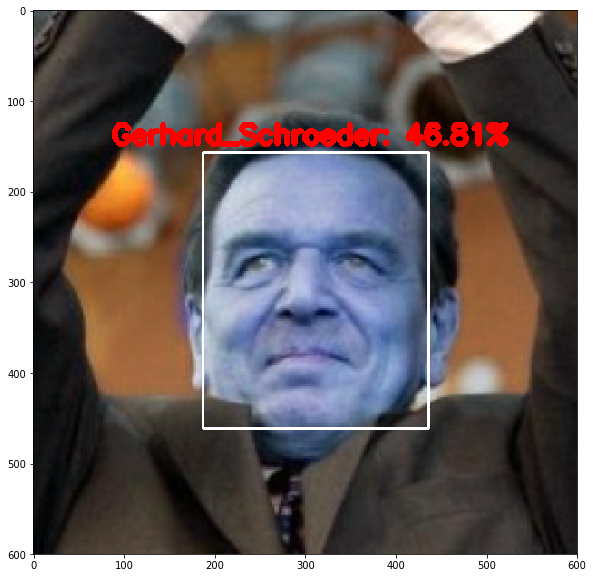

In [167]:
# # Looping for all images under test folder
# for (i, file) in enumerate(testimagePaths):
  
# 	# Extracting file name to create output file
#   imgpath, filename = os.path.split(file)
#   file_name = filename.split('.')[0]
#   label = imgpath.split('/')[-1]

file = testimagePaths[12]
print(file)
image = cv2.imread(file)
image = imutils.resize(image, width=600)
(h,w) = image.shape[:2]
imageBlob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300),(104.0, 177.0, 123.0), swapRB=False, crop=False)
detector.setInput(imageBlob)
detections = detector.forward()

if (len(detections) > 0):
  # to find the bounding box with the largest probability
  i = np.argmax(detections[0, 0, :, 2])
  confidence = detections[0, 0, i, 2]

threshold = 0.5
if confidence > threshold:
  box = detections[0, 0, i, 3:7] * np.array([w,h,w,h])
  (xTL, yTL, xBR, yBR) = box.astype("int")

face = image[yTL:yBR, xTL:xBR]
(fh,fw) = face.shape[:2]

# ensure the face width and height are sufficiently large
if(fw<20 or fh<20):
  print("skipped for image as face is too small:", file_name)
  exit(0)

faceBlob = cv2.dnn.blobFromImage(face, 1.0/255, (96, 96),(0,0,0), swapRB=True, crop=False)
embedder.setInput(faceBlob)
vec = embedder.forward()

# perform classification to recognize the face
preds = recognizer.predict_proba(vec)[0]
proba = preds[np.argmax(preds)]
name = le.classes_[np.argmax(preds)]
print(proba)

# draw the bounding box of the face along with the associated
# probability
text = "{}: {:.2f}%".format(name, proba * 100)
y = yTL - 10 if yTL - 10 > 10 else yTL + 10
cv2.rectangle(image, (xTL, yTL), (xBR, yBR),(255, 255, 255), 2)
cv2.putText(image, text, (xTL-100, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 5)

# show the output image
plt.figure(figsize=(20,10))
plt.imshow(image)
# cv2.waitKey(0)

  #   break


#### Why it performs poorly?

- Less Data
- Not so well aligned faces
- Not so well trained models or hyper-parameters
- The dlib library gives better results, but without GPU, performance is very slow.

In [181]:
# Initilization

genuine_scores = []
impostor_scores = []
identity = []
test = []
test_scores = []
thresh = 0.15

# Different directories of images for testing
# imagePaths: (separate folders with images)
# testimagePaths: (mixture test images)

for (idx, test_img) in enumerate(imagePaths):

	# Extracting file name to create output file
  test_imgpath, test_filename = os.path.split(test_img)
  test_file_name = test_filename.split('.')[0]
  test_label = test_imgpath.split('/')[-1]
  
  image = cv2.imread(test_img)
  image = imutils.resize(image, width=600)
  (h,w) = image.shape[:2]

  imageBlob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300),(104.0, 177.0, 123.0), swapRB=False, crop=False)
  detector.setInput(imageBlob)
  detections = detector.forward()
  
  for i in range(len(detections)):
    # to find the bounding box with the largest probability
    i = np.argmax(detections[0, 0, :, 2])
    confidence = detections[0, 0, i, 2]
#     print(confidence)
       
    box = detections[0, 0, i, 3:7] * np.array([w,h,w,h])
    (xTL, yTL, xBR, yBR) = box.astype("int")
    face = image[yTL:yBR, xTL:xBR]
    (fh,fw) = face.shape[:2]

    # ensure the face width and height are sufficiently large
    if (fw < 20 or fh < 20):
      continue

    faceBlob = cv2.dnn.blobFromImage(face, 1.0/255, (96, 96),(0,0,0), swapRB=True, crop=False)
    embedder.setInput(faceBlob)
    vec = embedder.forward()

    # Classification for face recognition
    preds = recognizer.predict_proba(vec)[0]
    pred_max = np.argmax(preds)
    pred_prob = preds[pred_max]
  
  test_scores.append(round(pred_prob,4))
    
print(len(test_scores),"\n",test_scores)


106 
 [0.3661, 0.4086, 0.3058, 0.4037, 0.3862, 0.4043, 0.2569, 0.3735, 0.2406, 0.3142, 0.2088, 0.265, 0.2495, 0.2945, 0.2502, 0.2604, 0.2474, 0.2379, 0.2519, 0.261, 0.352, 0.4029, 0.3436, 0.4699, 0.3559, 0.3095, 0.4554, 0.3108, 0.4394, 0.1491, 0.2233, 0.2713, 0.4681, 0.3512, 0.1803, 0.4227, 0.4141, 0.4132, 0.3492, 0.3441, 0.2858, 0.3685, 0.3992, 0.2215, 0.398, 0.1925, 0.415, 0.1759, 0.3336, 0.2545, 0.3039, 0.4788, 0.3792, 0.5152, 0.4759, 0.478, 0.2869, 0.4881, 0.1772, 0.3684, 0.1773, 0.2431, 0.4232, 0.3769, 0.3215, 0.2919, 0.3478, 0.2503, 0.3517, 0.3591, 0.2656, 0.4395, 0.4759, 0.2242, 0.7613, 0.5761, 0.7504, 0.6458, 0.6468, 0.2988, 0.4085, 0.4304, 0.4525, 0.3082, 0.314, 0.2144, 0.4371, 0.3678, 0.2347, 0.2877, 0.3791, 0.4338, 0.3329, 0.3225, 0.3033, 0.3033, 0.247, 0.4535, 0.3623, 0.3563, 0.2053, 0.2176, 0.2373, 0.3456, 0.3156, 0.1655]


In [182]:
# Unknown images
imagePaths[100:106]

['./DeepFace/face-recognition-master/images/Unknown/ian_malcolm.jpg',
 './DeepFace/face-recognition-master/images/Unknown/own_grady.jpg',
 './DeepFace/face-recognition-master/images/Unknown/claire_dearing.jpg',
 './DeepFace/face-recognition-master/images/Unknown/john_hammond.jpg',
 './DeepFace/face-recognition-master/images/Unknown/alan_grant.jpg',
 './DeepFace/face-recognition-master/images/Unknown/ellie_sattler.jpg']

In [183]:
#reference values of images
one=np.ones(100).tolist()
one.extend([0, 0, 0, 0, 0, 0])
identical=np.asarray(one).astype(int).tolist()
print(len(identical),"\n",identical)

106 
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]


In [0]:
for k in range(len(identical)):
  if identical[k]==1:
      genuine_scores.append(test_scores[k])

  else:
      impostor_scores.append(test_scores[k])


In [185]:
print(genuine_scores)
print(impostor_scores)

[0.3661, 0.4086, 0.3058, 0.4037, 0.3862, 0.4043, 0.2569, 0.3735, 0.2406, 0.3142, 0.2088, 0.265, 0.2495, 0.2945, 0.2502, 0.2604, 0.2474, 0.2379, 0.2519, 0.261, 0.352, 0.4029, 0.3436, 0.4699, 0.3559, 0.3095, 0.4554, 0.3108, 0.4394, 0.1491, 0.2233, 0.2713, 0.4681, 0.3512, 0.1803, 0.4227, 0.4141, 0.4132, 0.3492, 0.3441, 0.2858, 0.3685, 0.3992, 0.2215, 0.398, 0.1925, 0.415, 0.1759, 0.3336, 0.2545, 0.3039, 0.4788, 0.3792, 0.5152, 0.4759, 0.478, 0.2869, 0.4881, 0.1772, 0.3684, 0.1773, 0.2431, 0.4232, 0.3769, 0.3215, 0.2919, 0.3478, 0.2503, 0.3517, 0.3591, 0.2656, 0.4395, 0.4759, 0.2242, 0.7613, 0.5761, 0.7504, 0.6458, 0.6468, 0.2988, 0.4085, 0.4304, 0.4525, 0.3082, 0.314, 0.2144, 0.4371, 0.3678, 0.2347, 0.2877, 0.3791, 0.4338, 0.3329, 0.3225, 0.3033, 0.3033, 0.247, 0.4535, 0.3623, 0.3563]
[0.2053, 0.2176, 0.2373, 0.3456, 0.3156, 0.1655]


In [0]:
thresholds = np.linspace(0.0, 1.0, 50,dtype=list, endpoint=False).tolist()
len_t = len(thresholds)
len_s = len(test_scores)

f1 = np.zeros(len_t)
acc = np.zeros(len_t)

for i in range(len_t):
    pred_scores=[]
    for j in range(len_s):
        if test_scores[j] < thresholds[i]: #anything below threshold is considered not matching
            pred_scores.append(0)
        elif test_scores[j] > thresholds[i]: #anything equal or greater than threshold is considered as truely identical
            pred_scores.append(1)

#     f1[i] = f1_score(identical,pred_scores)
    f1[i] = f1_score(identical, pred_scores, average='weighted', labels=np.unique(pred_scores))
    acc[i] = accuracy_score(identical,pred_scores)


In [187]:
opt_thresh = thresholds[np.where(f1 == np.amax(f1))[0][-1]]
opt_thresh

0.14

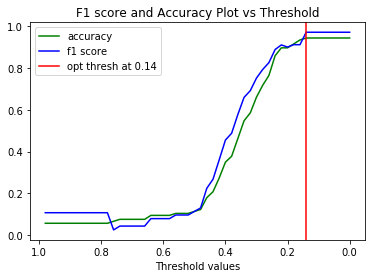

In [196]:
# Plot F1 score and accuracy as function of distance threshold
def plot_f1_acc(f1,acc,thresh):
    plt.gca().invert_xaxis()
    plt.plot(thresh, acc, 'g',label='accuracy') # plotting t, a separately 
    plt.plot(thresh, f1, 'b',label='f1 score') # plotting t, b separately 
    plt.axvline(x=opt_thresh,c='r',label='opt thresh at {}'.format(opt_thresh))
    plt.title("F1 score and Accuracy Plot vs Threshold")
    plt.xlabel("Threshold values")
    plt.legend(loc='upper left')
    plt.show()
    
plot_f1_acc(f1,acc,thresholds)

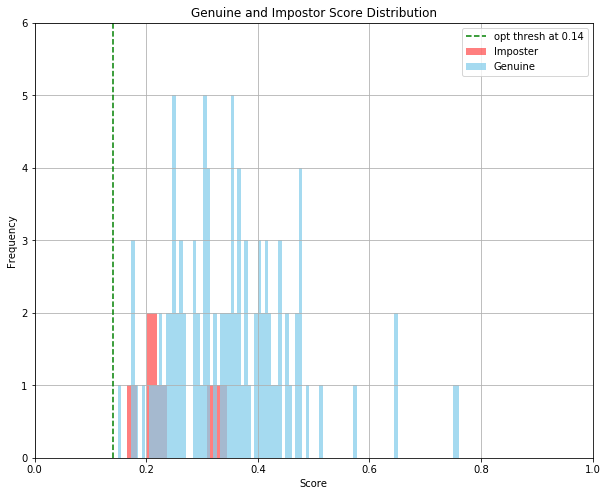

In [195]:
def plot_scores(impostor, genuine):

    fig, ax = plt.subplots(figsize=(10, 8))
    # Set axis ranges; by default this will put major ticks every 25.
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 6)
    # Draws a histogram to show score frequencies with values.
    plt.hist(impostor, facecolor='red',alpha=0.5, bins = 10, label='Imposter')
    plt.hist(genuine, facecolor='skyblue',alpha=0.75, bins = 100, label='Genuine')
    plt.axvline(x=opt_thresh,c='g',ls='--', label='opt thresh at {}'.format(opt_thresh))
    plt.legend(loc='upper right')

    # Adding labels and titles to the plot
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.title('Genuine and Impostor Score Distribution')
    plt.grid(True)


    # show the plot
    plt.show()


plot_scores(impostor_scores,genuine_scores)